In [1]:
import math
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import pickle
import numpy as np
import pandas as pd
from Utils.utils import rolling_percentile

In [8]:
with open(f'Caches/.NSEI/D/MarketBreadthPivotsOverBoughtOverSold/Data/Features.pkl','rb') as file:
    data_inp = pickle.load(file)

In [9]:
def add_pivot_features(data, col, n, shift=True):
    data[f"{col}_TypeCurrentPivot"] = np.where(data[f"{col}_IsHighPivot"]==1, 1, np.nan)
    data[f"{col}_TypeCurrentPivot"] = np.where(data[f"{col}_IsLowPivot"]==1, -1, data[f"{col}_TypeCurrentPivot"])
    data[f"{col}_PivotValue"] = np.where(data[f"{col}_IsHighPivot"]==1, data[f"{col}"], np.nan)
    data[f"{col}_PivotValue"] = np.where(data[f"{col}_IsLowPivot"]==1, data[f"{col}"], data[f"{col}_PivotValue"])
    data[f"{col}_TypePreviousPivot"] = data[f"{col}_TypeCurrentPivot"].fillna(method='ffill').shift(1).fillna(0)
    data[f"{col}_PreviousPivotValue"] = data[f"{col}_PivotValue"].fillna(method='ffill').shift(1).fillna(0)
    data[f"{col}_TypePreviousPivot"] = np.where(np.isnan(data[f"{col}_TypeCurrentPivot"]), np.nan, data[f"{col}_TypePreviousPivot"])
    data[f"{col}_PreviousPivotValue"] = np.where(np.isnan(data[f"{col}_PivotValue"]), np.nan, data[f"{col}_PreviousPivotValue"])
    data[f"{col}_PreviousHighPivotValue"] = pd.DataFrame(np.where(((data[f"{col}_TypePreviousPivot"]==-1)),data[f"{col}_PivotValue"],np.nan)).fillna(method='ffill').shift(1)
    data[f"{col}_PreviousLowPivotValue"] = pd.DataFrame(np.where(((data[f"{col}_TypePreviousPivot"]==1)),data[f"{col}_PivotValue"],np.nan)).fillna(method='ffill').shift(1)
    data[f"{col}_DaysSincePreviousHighPivot"] = np.nan
    data[f"{col}_DaysSincePreviousLowPivot"] = np.nan    
    for i in range(1,len(data)):
        if data.iloc[i][f"{col}_TypeCurrentPivot"]==1:
            data.loc[i, f"{col}_DaysSincePreviousHighPivot"] = 0
            data.loc[i, f"{col}_DaysSincePreviousLowPivot"] = data.loc[i-1, f"{col}_DaysSincePreviousLowPivot"] + (data.loc[i, "Datetime"]- data.loc[i-1, "Datetime"]).days
        elif data.iloc[i][f"{col}_TypeCurrentPivot"]==-1:
            data.loc[i, f"{col}_DaysSincePreviousHighPivot"] = data.loc[i-1, f"{col}_DaysSincePreviousHighPivot"] + (data.loc[i, "Datetime"]- data.loc[i-1, "Datetime"]).days
            data.loc[i, f"{col}_DaysSincePreviousLowPivot"] = 0
        else:
            try:
                data.loc[i, f"{col}_DaysSincePreviousHighPivot"] = data.loc[i-1, f"{col}_DaysSincePreviousHighPivot"] + (data.loc[i, "Datetime"]- data.loc[i-1, "Datetime"]).days
                data.loc[i, f"{col}_DaysSincePreviousLowPivot"] = data.loc[i-1, f"{col}_DaysSincePreviousLowPivot"] + (data.loc[i, "Datetime"]- data.loc[i-1, "Datetime"]).days
            except:
                continue
    if shift:
        data[f"{col}_TypeCurrentPivot"] = data[f"{col}_TypeCurrentPivot"].shift(n)
        data[f"{col}_PivotValue"] = data[f"{col}_PivotValue"].shift(n)
        data[f"{col}_TypePreviousPivot"] = data[f"{col}_TypePreviousPivot"].shift(n)
        data[f"{col}_PreviousPivotValue"] = data[f"{col}_PreviousPivotValue"].shift(n)
        data[f"{col}_PreviousHighPivotValue"] = data[f"{col}_PreviousHighPivotValue"].shift(n)
        data[f"{col}_PreviousLowPivotValue"] = data[f"{col}_PreviousLowPivotValue"].shift(n)
        data[f"{col}_DaysSincePreviousHighPivot"] = data[f"{col}_DaysSincePreviousHighPivot"].shift(n)
        data[f"{col}_DaysSincePreviousLowPivot"] = data[f"{col}_DaysSincePreviousLowPivot"].shift(n)
        data[f"{col}_IsHighPivot"] = data[f"{col}_IsHighPivot"].shift(n)
        data[f"{col}_IsLowPivot"] = data[f"{col}_IsLowPivot"].shift(n)

    return data

Identifying Pivots on Indicator Space based on comparison with Last n and Next n values

In [10]:
def compare_for_high_pivot(inp):
    x = inp.copy()
    n = int((len(x)-1)/2)
    x = np.array(x)
    if x.std()==0:
        return np.nan
    conditionals = []
    for i in range(0,n):
        conditionals.append(x[i]<=x[i+1])
    for i in range(n,len(x)-1):
        conditionals.append(x[i]>=x[i+1])
    if (len(set(conditionals))==1)&(list(set(conditionals))[0]):
        return 1
    else:
        return np.nan

def compare_for_low_pivot(inp):
    x = inp.copy()
    n = int((len(x)-1)/2)
    x = np.array(x)
    if x.std()==0:
        return np.nan
    conditionals = []
    for i in range(0,n):
        conditionals.append(x[i]>=x[i+1])
    for i in range(n,len(x)-1):
        conditionals.append(x[i]<=x[i+1])
    if (len(set(conditionals))==1)&(list(set(conditionals))[0]):
        return 1
    else:
        return np.nan

In [11]:
def add_pivot_Comparison_with_values(data, col, n, shift=True, plot=True):
    data[f"{col}_IsHighPivot"] = data[col].rolling(2*n+1, center=True).apply(compare_for_high_pivot)
    data[f"{col}_IsLowPivot"] = data[col].rolling(2*n+1, center=True).apply(compare_for_low_pivot)
    data = add_pivot_features(data, col, n, shift)
    if plot:
        plt.plot(data['Datetime'], data[col], color='black', label=col)
        plt.plot(data[data[f"{col}_IsHighPivot"]==1]['Datetime'], data[data[f"{col}_IsHighPivot"]==1][f"{col}_PivotValue"], color='black', marker='o', ms=5, linestyle = 'None',mec='r')
        plt.plot(data[data[f"{col}_IsLowPivot"]==1]['Datetime'], data[data[f"{col}_IsLowPivot"]==1][f"{col}_PivotValue"], color='black', marker='o', ms=5, linestyle = 'None',mec='g')
        plt.legend()
    return data
    

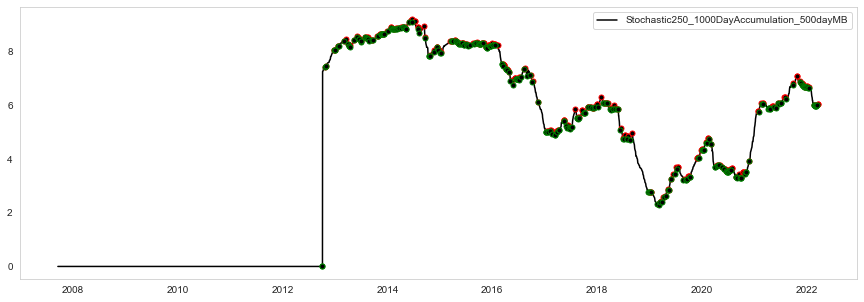

In [12]:
col = "Stochastic250_1000DayAccumulation_500dayMB"
n = 2
data = add_pivot_Comparison_with_values(data_inp.copy(), col, n, shift=False)

Important Pivot Detection on the basis of Sharpe

In [ ]:
def add_important_pivot_Sharpe(data, n, percentile_rolling_window = 100, threshold = 0.95, shift=True, plot=True):

    data["Return"] = data["Close"].pct_change()
    for i in range(1,n+1):
        data[f"FReturn{i}"] = data["Return"].shift(-i)

    data["Return"] = data["Close"].pct_change()
    for i in range(1,n+1):
        data[f"BReturn{i}"] = data["Return"].shift(i)

    data["FSharpe"] = data[[f"FReturn{i}" for i in range(1,n+1)]].mean(axis=1)/data[[f"FReturn{i}" for i in range(1,n+1)]].std(axis=1)
    data.loc[data['FSharpe'] > 10, 'FSharpe'] = 10
    data.loc[data['FSharpe'] < -10, 'FSharpe'] = -10

    data["BSharpe"] = data[[f"BReturn{i}" for i in range(1,n+1)]].mean(axis=1)/data[[f"BReturn{i}" for i in range(1,n+1)]].std(axis=1)
    data.loc[data['BSharpe'] > 10, 'BSharpe'] = 10
    data.loc[data['BSharpe'] < -10, 'BSharpe'] = -10

    data["SharpesDiff"] = data[[f"BReturn{i}" for i in range(1,n+1)]].mean(axis=1)/data[[f"BReturn{i}" for i in range(1,n+1)]].std(axis=1)-\
                             data[[f"FReturn{i}" for i in range(1,n+1)]].mean(axis=1)/data[[f"FReturn{i}" for i in range(1,n+1)]].std(axis=1)

    data["Percentile_SharpesDiff"] = rolling_percentile([data,percentile_rolling_window,["SharpesDiff"]])
    col = "Close"
    data[f"{col}_IsHighPivot"] = np.where((data["Percentile_SharpesDiff"]>=threshold)&(data["SharpesDiff"]>0),1,np.nan)
    data[f"{col}_IsLowPivot"] = np.where((data["Percentile_SharpesDiff"]<=1-threshold)&(data["SharpesDiff"]<0),1,np.nan)

    data = add_pivot_features(data, col, n, shift)
    if plot:
        plt.plot(data['Datetime'], data[col], color='black', label=col)
        plt.plot(data[data[f"{col}_IsHighPivot"]==1]['Datetime'], data[data[f"{col}_IsHighPivot"]==1][f"{col}_PivotValue"], color='black', marker='o', ms=5, linestyle = 'None',mec='r')
        plt.plot(data[data[f"{col}_IsLowPivot"]==1]['Datetime'], data[data[f"{col}_IsLowPivot"]==1][f"{col}_PivotValue"], color='black', marker='o', ms=5, linestyle = 'None',mec='g')
        plt.legend()
    return data


In [ ]:
n = 30
data = add_important_pivot_Sharpe(data_inp.copy(), n, percentile_rolling_window = 120,threshold=0.999, shift=False)

In [ ]:
list(data.columns)

Important Pivot Detection on the basis of HPR

In [ ]:
def HPR_from_returns(returns):
    hpr = 1
    for ret in returns:
        hpr = hpr*(1+ret)
    hpr = hpr**(1/len(returns))-1
    return hpr

In [ ]:
def add_important_pivot_GM(data, n, percentile_rolling_window = 100, threshold = 0.95, shift=True, plot=True):

    data["Return"] = data["Close"].pct_change()
    for i in range(1,n+1):
        data[f"FReturn{i}"] = data["Return"].shift(-i)

    data["Return"] = data["Close"].pct_change()
    for i in range(1,n+1):
        data[f"BReturn{i}"] = data["Return"].shift(i)

    data["FHPR"] = np.nan
    data["BHPR"] = np.nan
    for row in range(len(data)):
        data.loc[row, "FHPR"] = HPR_from_returns(list(data.loc[row, [f"FReturn{i}" for i in range(1,n+1)]]))
        data.loc[row, "BHPR"] = HPR_from_returns(list(data.loc[row, [f"BReturn{i}" for i in range(1,n+1)]]))

    data["HPRDiff"] = data["BHPR"]- data["FHPR"]

    data["Percentile_HPRDiff"] = rolling_percentile([data,percentile_rolling_window,["HPRDiff"]])
    col = "Close"
    data[f"{col}_IsHighPivot"] = np.where((data["Percentile_HPRDiff"]>=threshold)&(data["HPRDiff"]>0),1,np.nan)
    data[f"{col}_IsLowPivot"] = np.where((data["Percentile_HPRDiff"]<=1-threshold)&(data["HPRDiff"]<0),1,np.nan)

    data = add_pivot_features(data, col, n, shift)
    if plot:
        plt.plot(data['Datetime'], data[col], color='black', label=col)
        plt.plot(data[data[f"{col}_IsHighPivot"]==1]['Datetime'], data[data[f"{col}_IsHighPivot"]==1][f"{col}_PivotValue"], color='black', marker='o', ms=5, linestyle = 'None',mec='r')
        plt.plot(data[data[f"{col}_IsLowPivot"]==1]['Datetime'], data[data[f"{col}_IsLowPivot"]==1][f"{col}_PivotValue"], color='black', marker='o', ms=5, linestyle = 'None',mec='g')
        plt.legend()
    return data


In [ ]:
n = 30
data = add_important_pivot_GM(data_inp.copy(), n, percentile_rolling_window=100, threshold=0.999, shift=False)

Printing fisher pivots

In [ ]:
from Utils.add_features import add_fisher
data = add_fisher([data, 120])


In [ ]:
col = "Fisher120"
n = 2
data = add_pivot_Comparison_with_values(data.copy(), col, n, shift=False)


In [ ]:
data_test = data.copy()
col = "Close"
fisher_lb = 120
n = 3
for i in range(n,len(data_test)-n):
    conds_high = [(data_test.iloc[i][f"Fisher{fisher_lb}_IsHighPivot"]==1)]
    for j in range(1,n+1):
        conds_high.append((data_test.iloc[i-j][f"Fisher{fisher_lb}_IsHighPivot"]==1))
        conds_high.append((data_test.iloc[i+j][f"Fisher{fisher_lb}_IsHighPivot"]==1))
    if True in list(set(conds_high)):
        cond_high=True
    else:
        cond_high=False
    if (data_test.iloc[i][f"{col}_IsHighPivot"]==1)&(cond_high):
        data_test.loc[i, f"{col}_IsHighPivot"] = 1
    else:
        data_test.loc[i, f"{col}_IsHighPivot"] = 0

    conds_low = [(data_test.iloc[i][f"Fisher{fisher_lb}_IsLowPivot"]==1)]
    for j in range(1,n+1):
        conds_low.append((data_test.iloc[i-j][f"Fisher{fisher_lb}_IsLowPivot"]==1))
        conds_low.append((data_test.iloc[i+j][f"Fisher{fisher_lb}_IsLowPivot"]==1))
    if True in list(set(conds_low)):
        cond_low=True
    else:
        cond_low=False
    if (data_test.iloc[i][f"{col}_IsLowPivot"]==1)&(cond_low):
        data_test.loc[i, f"{col}_IsLowPivot"] = 1
    else:
        data_test.loc[i, f"{col}_IsLowPivot"] = 0
plt.plot(data_test['Datetime'], data_test[col], color='black', label=col)
plt.plot(data_test[data_test[f"{col}_IsHighPivot"]==1]['Datetime'], data_test[data_test[f"{col}_IsHighPivot"]==1][f"{col}_PivotValue"], color='black', marker='o', ms=5, linestyle = 'None',mec='r')
plt.plot(data_test[data_test[f"{col}_IsLowPivot"]==1]['Datetime'], data_test[data_test[f"{col}_IsLowPivot"]==1][f"{col}_PivotValue"], color='black', marker='o', ms=5, linestyle = 'None',mec='g')
plt.legend()

Strategy-1

1) BUY: Previous Pivot is Oversold, Current Pivot is Not Oversold and is less than the previos pivot (Low pivots)
2) SELL: Previous Pivot is Overbought, Current Pivot is Not Overbought and is higher than the previos pivot

Overbought: Stochastic>8
Oversold: Stochastic<2

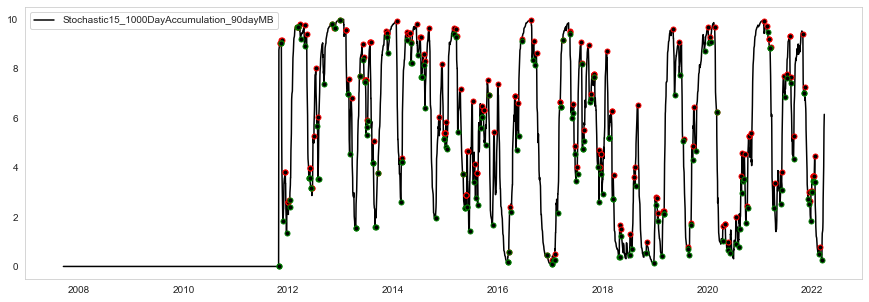

In [13]:
col = "Stochastic15_1000DayAccumulation_90dayMB"
n = 2
data = add_pivot_Comparison_with_values(data_inp.copy(), col, n)


In [14]:
#Generate Signals
buy_mask = (data[f"{col}_PreviousPivotValue"] < 2) & (data[f"{col}_PivotValue"] > 2) & (data[f"{col}_PivotValue"]<data[f"{col}_PreviousPivotValue"])
sell_mask = (data[f"{col}_PreviousPivotValue"] > 8) & (data[f"{col}_PivotValue"] < 8) & (data[f"{col}_PivotValue"]>data[f"{col}_PreviousPivotValue"])

bval = +1
sval = 0  # -1 if short selling is allowed, otherwise 0

data['signal'] = np.nan
data.loc[buy_mask, 'signal'] = bval
data.loc[sell_mask, 'signal'] = sval
data.signal = data.signal.fillna(method="ffill")
data.signal = data.signal.fillna(0)

In [20]:
buy_mask

TypeError: no numeric data to plot

In [15]:
#Backtest

allocation = 10000
int = 6
annual_factor = 252

# creating returns and portfolio value series #This code runs compulsorily
data['Return'] = np.log(data['Close'] / data['Close'].shift(1))
data['S_Return'] = data['signal'].shift(1) * data['Return']
data['S_Return'] = data['S_Return'].fillna(0)
data["S_Return"] = data["S_Return"] + (int/(100*annual_factor))*(1-data['signal'].shift(1))
data['Market_Return'] = np.exp(data['Return'].expanding().sum())
data['Strategy_Return'] = np.exp( data['S_Return'].expanding().sum())
data['Portfolio_Value'] = ((data['Strategy_Return'] + 1) * allocation)

mask = ((data.signal == 1) & (data.signal.shift(1) == 0)) & (data.signal.notnull())
data['trade_num'] = np.where(mask, 1, 0).cumsum()

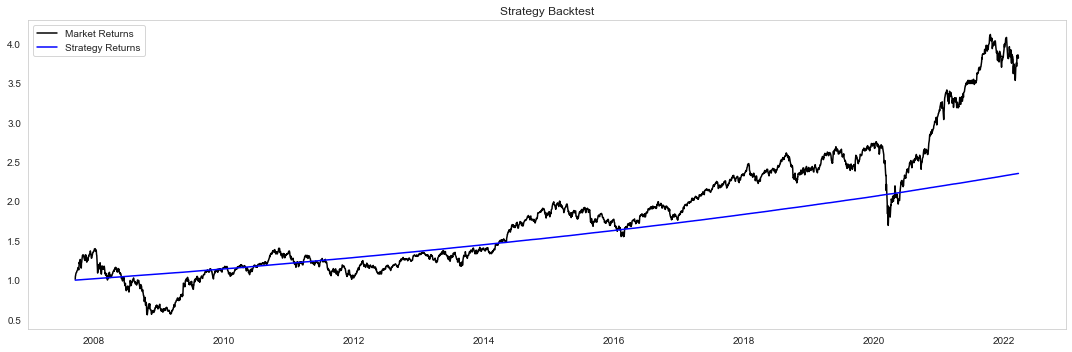

In [16]:
plt.plot(data['Datetime'], data['Market_Return'], color='black', label='Market Returns')
plt.plot(data['Datetime'], data['Strategy_Return'], color='blue', label='Strategy Returns')
# plt.plot(data['Date'],data['fisher_rate'],color='red', label= 'Fisher Rate')
plt.title('Strategy Backtest')
plt.legend(loc=0)
plt.tight_layout()